<a href="https://colab.research.google.com/github/KrishnanandSingh/EVA/blob/master/Project-10/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [10]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0715 06:00:13.932546 139730425063296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 06:00:13.982983 139730425063296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 06:00:13.990939 139730425063296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 06:00:14.039844 139730425063296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 17s 0us/step


W0715 06:00:31.932883 139730425063296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0715 06:00:31.934468 139730425063296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Print summary to find layer names

In [11]:
model = VGG16(weights="imagenet")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [12]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

180


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [13]:
import keras.backend as K

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [14]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

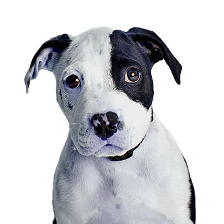

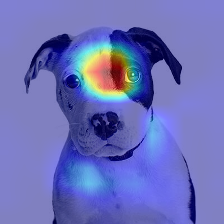

In [15]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

Since we are going to use this repeatedly, let's define a method to display gradcam.

In [0]:
import keras.backend as K
from google.colab.patches import cv2_imshow

def display_gradcam(class_output, last_conv_layer, input_img):
  grads = K.gradients(class_output, last_conv_layer.output)[0]  #(?, 14, 14, 512)
  pooled_grads = K.mean(grads, axis=(0, 1, 2)) #(512,)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1) #(14, 14)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(input_img, 0.5, heatmap, 0.5, 0)
  cv2_imshow( input_img)
  cv2_imshow(superimposed_img)

Display gradcam result for second last layer

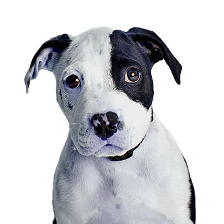

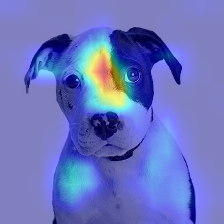

In [17]:
conv_layer = model.get_layer("block5_conv2") #(14, 14, 512)
display_gradcam(class_output, conv_layer, dog)

Display gradcam result for third last layer

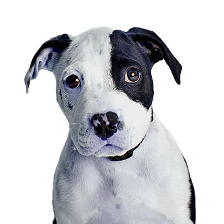

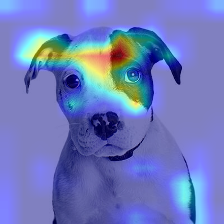

In [18]:
conv_layer = model.get_layer("block5_conv1") #(14, 14, 512)
display_gradcam(class_output, conv_layer, dog)

The png image contains 4 channels, 4th one being alpha channel to store transaparency information

Converting (224, 224, 4) to (224, 224, 3)

In [0]:
imageRJnr = io.imread("https://user-images.githubusercontent.com/6766061/61188403-14779100-a69c-11e9-8c72-5b59368807aa.png")
imageRJnr = cv2.resize(imageRJnr[:,:,:-1], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(imageRJnr)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Looking into imagenet dataset we see that index of sunglass is 836

```txt
836: 'sunglass',
837: 'sunglasses, dark glasses, shades',
```

Identifying sunglasses

---
Src: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

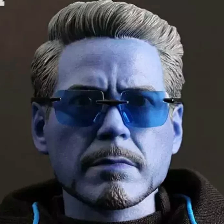

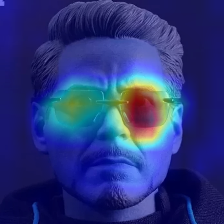

In [32]:
index_sunglasses = 836
class_output = model.output[:, index_sunglasses]
conv_layer = model.get_layer("block5_conv3")
display_gradcam(class_output, conv_layer, imageRJnr)